In [1]:
import numpy as np
import matplotlib.pyplot as plt
from source import source

In [2]:
class MQAM_constellation(object):
    def __init__(self, m):
        self.m = m
        self.sqrt_m = int( np.sqrt(self.m))
        self.gray_code = None
        self.gray_to_symbol_map = {}
        self.symbol_to_gray_map = {}
        self.norm_complex_constellation = {}
        self.complex_constellation = {}
        
        self.__init_constellation()
    
    def __generate_gray_code(self, codeword_len):
        if codeword_len < 1:
            raise Exception('Length sould be at least 1')

        if codeword_len == 1:
            return ['0', '1']

        prev_gray_code = self.__generate_gray_code(codeword_len - 1)

        gray_code = ["0" + s for s in prev_gray_code]
        gray_code += ['1' + s for s in prev_gray_code[::-1]]
        return gray_code
    
    def _create_gray_code(self):
        self.gray_code = self.__generate_gray_code(self.sqrt_m)
        return self.gray_code 
    
    def gray_to_symbols(self):
        gray_code = self.gray_code
        s = int(np.sqrt(len(gray_code)))
        g = np.array(gray_code, dtype=object).reshape(s, s)
        for r in range(1, g.shape[0] + 1, 2):
            g[r] = g[r][::-1]


        gray_to_symbol_map = {}
        symbol_to_gray_map = {}

        rows, cols = g.shape
        for r in range(rows):
            for c in range(cols):
                i = 1+c+ r*cols
                code = g[r,c]
                self.gray_to_symbol_map[code] = f's{i}'
                self.symbol_to_gray_map[f's{i}'] = code 
        
        return symbol_to_gray_map, gray_to_symbol_map
    
    def create_normalized_complex_constellation(self):
        def coordonate_from_index(i, max_index):
            return 2*i - max_index

        for r in range(self.sqrt_m):
            for c in range(self.sqrt_m):
                i = 1+c + r * self.sqrt_m
                v = coordonate_from_index(c, self.sqrt_m-1) + 1j * \
                    coordonate_from_index(self.sqrt_m-r, self.sqrt_m+1)
                self.norm_complex_constellation[f's{i}'] = v /((self.sqrt_m-1))
        return self.norm_complex_constellation
    
    def __init_constellation(self):
        self._create_gray_code()
        self.gray_to_symbols()
        self.create_normalized_complex_constellation()
    
    def get_constellation(self, max_power):
        for k in self.norm_complex_constellation:
            self.complex_constellation[k] = self.norm_complex_constellation[k]* max_power/2
        return self.complex_constellation
    
    def bit_to_symb(self,b):
        symb_len = int(np.log2(self.m))
        seq_len = len(b)//symb_len
        self.symb_sequence = []
        self.comp_symb_sequence = []
        for i in range(seq_len):
            sub_b = b[i*symb_len:(i+1)*symb_len]
            sym = self.gray_to_symbol_map[sub_b]
            self.symb_sequence.append(sym)
            self.comp_symb_sequence.append(self.complex_constellation[sym])
        return self.symb_sequence, self.comp_symb_sequence
    
    def plot_constellation(self,cnst):
        
        cnst = list(cnst.values())
        flatten = np.array(cnst).reshape(-1,)
        r = np.real(flatten)
        i = np.imag(flatten)
        epsilon = max(r)*0.25
        xlim = [min(r)-epsilon,max(r)+epsilon]
        ylim = [min(i)-epsilon,max(i)+epsilon]
        
        plt.axes().set_aspect('equal')
        plt.grid(True)
        plt.plot([-100,100], [0,0], 'k-')
        plt.plot([0,0], [-100,100], 'k-')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.scatter(r, i)
        plt.show()
        
        
qam_16_cst = MQAM_constellation(16) 

_= qam_16_cst.norm_complex_constellation
_= qam_16_cst.get_constellation(6)


In [3]:
def symbols_to_signal_mapping(t, s, B):
    N= len(t)
    dt = t[1] - t[0]
    Ns= len(s)
    qs = []
    l1 = int(-1*np.floor(Ns/2))
    l2 = int(np.ceil(Ns/2))
    for i, l in enumerate(range(l1,l2)):
        
        qs.append( s[i]* np.sqrt(B)*np.sinc(B*t - l)*np.sqrt(dt) )
        
    
    return np.sum(qs,axis=0), qs

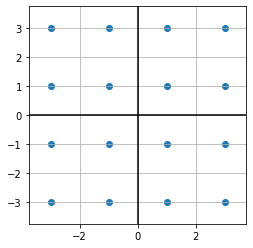

['s3', 's13', 's5', 's14', 's15', 's5', 's8', 's12', 's8', 's11', 's14', 's2', 's1', 's4', 's12', 's12', 's1', 's4', 's10', 's9', 's5', 's10', 's7', 's15', 's16', 's15', 's5', 's1', 's12', 's9', 's12', 's12']
[(1+3j), (-3-3j), (-3+1j), (-1-3j), (1-3j), (-3+1j), (3+1j), (3-1j), (3+1j), (1-1j), (-1-3j), (-1+3j), (-3+3j), (3+3j), (3-1j), (3-1j), (-3+3j), (3+3j), (-1-1j), (-3-1j), (-3+1j), (-1-1j), (1+1j), (1-3j), (3-3j), (1-3j), (-3+1j), (-3+3j), (3-1j), (-3-1j), (3-1j), (3-1j)]


In [4]:
if __name__ == '__main__':

    ber_p = 0.5
    ber_n = 128
    source(ber_n, ber_p)[1]
    bit_seq = source(ber_n, ber_p)[1]

    symb_seq, complex_seq = qam_16_cst.bit_to_symb(bit_seq)
    qam_16_cst.plot_constellation(qam_16_cst.norm_complex_constellation)
    qam_16_cst.plot_constellation(qam_16_cst.complex_constellation)
    
    print(symb_seq)
    print(complex_seq)